In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

# Catfish Sales Data

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
#read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser).squeeze("columns")

/tmp/ipykernel_29574/3497519950.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser).squeeze("columns")


In [5]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [6]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

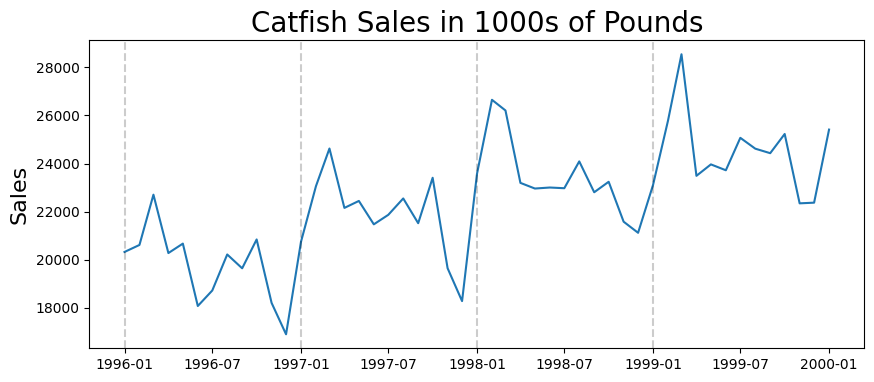

In [7]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [8]:
first_diff = lim_catfish_sales.diff()[1:]

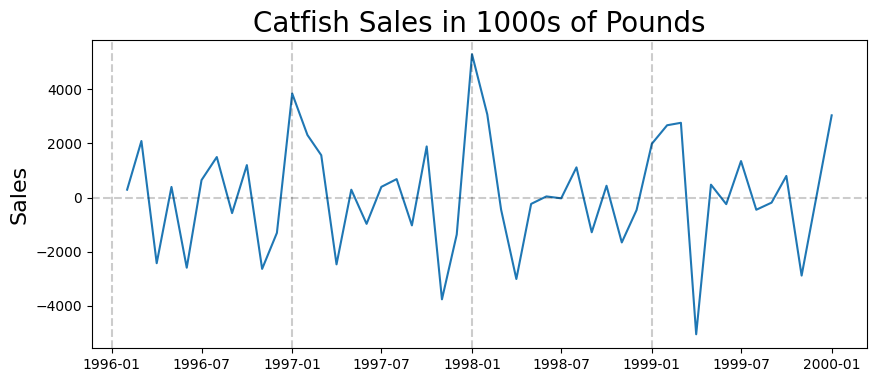

In [9]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

<BarContainer object of 17 artists>

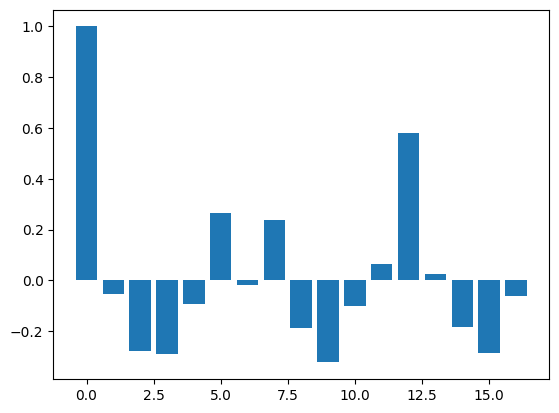

In [11]:
acf_vals = acf(first_diff)
num_lags = 17
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a seasonal MA process

# PACF

<BarContainer object of 15 artists>

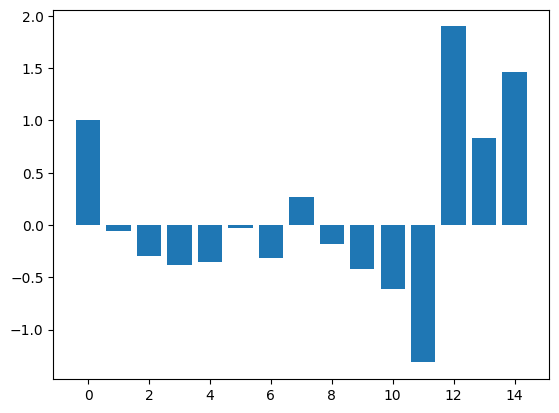

In [12]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [13]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

# Fit the SARIMA Model

In [14]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [15]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87281D+00    |proj g|=  1.21837D+00

At iterate    5    f=  8.58402D+00    |proj g|=  3.02840D-01

At iterate   10    f=  8.55739D+00    |proj g|=  1.37612D-03

At iterate   15    f=  8.55739D+00    |proj g|=  1.03982D-03

At iterate   20    f=  8.55722D+00    |proj g|=  2.64469D-02

At iterate   25    f=  8.53901D+00    |proj g|=  1.20428D-01

At iterate   30    f=  8.51094D+00    |proj g|=  1.23001D-02

At iterate   35    f=  8.50351D+00    |proj g|=  2.54109D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [16]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Wed, 20 Dec 2023   AIC                            737.269
Time:                                      13:51:39   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.51

In [17]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

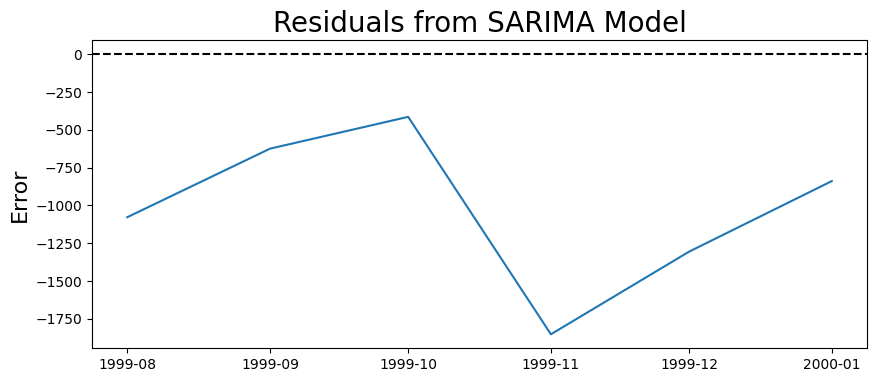

In [18]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

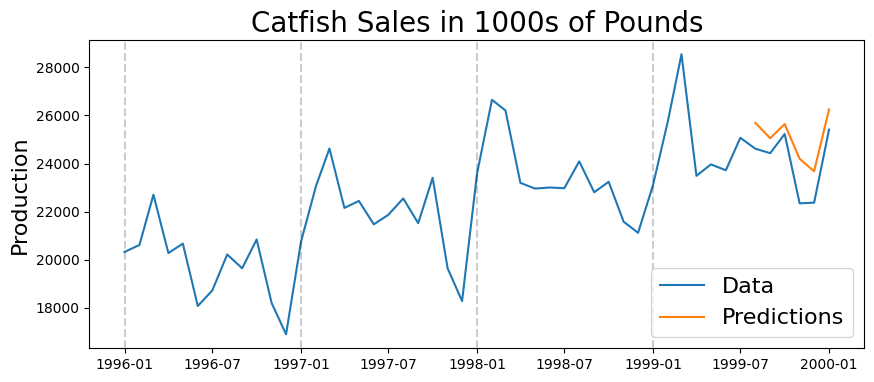

In [19]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [20]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0433


In [21]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.30856579027


# Using the Rolling Forecast Origin

In [22]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87281D+00    |proj g|=  1.21837D+00

At iterate    5    f=  8.58402D+00    |proj g|=  3.02840D-01

At iterate   10    f=  8.55739D+00    |proj g|=  1.37612D-03

At iterate   15    f=  8.55739D+00    |proj g|=  1.03982D-03

At iterate   20    f=  8.55722D+00    |proj g|=  2.64469D-02

At iterate   25    f=  8.53901D+00    |proj g|=  1.20428D-01

At iterate   30    f=  8.51094D+00    |proj g|=  1.23001D-02

At iterate   35    f=  8.50351D+00    |proj g|=  2.54109D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/tmp/ipykernel_29574/3978322752.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[25695.47522126]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions[train_end] = pred
/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   30    f=  8.51033D+00    |proj g|=  4.68820D-02

At iterate   35    f=  8.50189D+00    |proj g|=  2.08918D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     49      1     0     0   1.963D-05   8.502D+00
  F =   8.5017078613411918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87306D+00    |proj g|=  1.28325D+00

At iterate    5    f=  8.55757D+00    |proj g|=  2.84257D-01

At iter

/tmp/ipykernel_29574/3978322752.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   15    f=  8.53540D+00    |proj g|=  1.23855D-03

At iterate   20    f=  8.53526D+00    |proj g|=  1.47156D-02

At iterate   25    f=  8.52465D+00    |proj g|=  8.50519D-02

At iterate   30    f=  8.50627D+00    |proj g|=  6.19121D-02

At iterate   35    f=  8.49466D+00    |proj g|=  2.09949D-02

At iterate   40    f=  8.49427D+00    |proj g|=  6.71818D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     52      1     0     0   6.718D-07   8.494D+00
  F =   8.4942658989592523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/tmp/ipykernel_29574/3978322752.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/tmp/ipykernel_29574/3978322752.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/home/sampersie/.local/lib/


At iterate   10    f=  8.51410D+00    |proj g|=  1.40141D-03

At iterate   15    f=  8.51410D+00    |proj g|=  8.00193D-04

At iterate   20    f=  8.51404D+00    |proj g|=  1.53697D-02

At iterate   25    f=  8.50620D+00    |proj g|=  7.39400D-02

At iterate   30    f=  8.49669D+00    |proj g|=  3.73733D-02

At iterate   35    f=  8.48996D+00    |proj g|=  2.34972D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     46      1     0     0   6.810D-06   8.490D+00
  F =   8.4898467476872916     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/tmp/ipykernel_29574/3978322752.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/sampersie/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     39      1     0     0   7.403D-06   8.483D+00
  F =   8.4833339337597025     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/tmp/ipykernel_29574/3978322752.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred


In [23]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

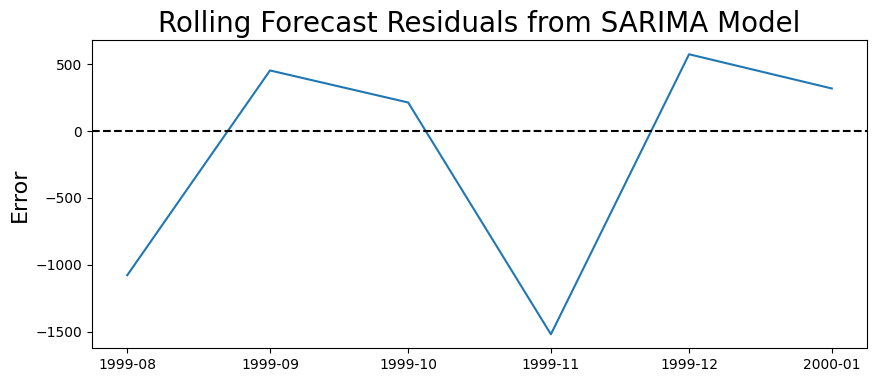

In [24]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

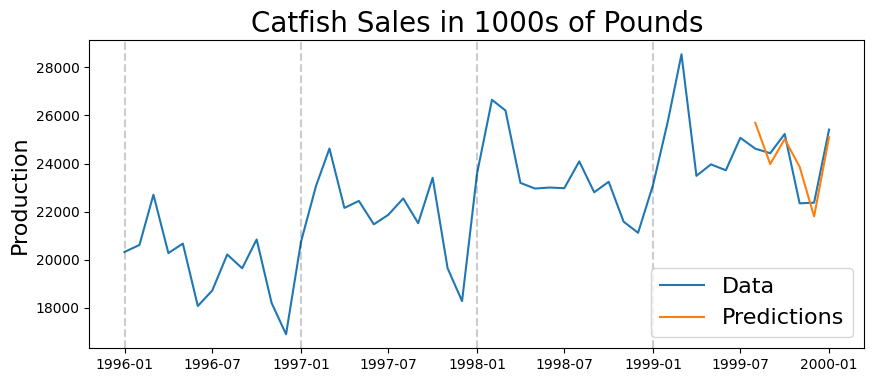

In [25]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [26]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0295


In [27]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 831.1514346237205
